In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
import matplotlib.pyplot as pyplot

from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'
figdir = '/g/data/hh5/tmp/access-om/fbd581/basal_mom5-collaborative-project/figures/'

In [2]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

<Client: 'tcp://127.0.0.1:36099' processes=28 threads=28>

In [3]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
control = '01deg_jra55v13_ryf9091_DSW'
master_session = cc.database.create_session(session_name)

session_name = '/g/data/ik11/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
      
# temperature of meltwater using Gade line:
basal_gade = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'
basal_gade_icb = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'
basal_nogade = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'
basal_gade_brine = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb_Brine'


In [4]:
%%time
# Make sure these match the available restarts:
start_time='1900-01-01'
end_time='1910-12-31'

lat_slice  = slice(-80,-59)

# load surface heat flux from different components:
pme_net = cc.querying.getvar(control, 'pme_net', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
pme_river = cc.querying.getvar(control, 'pme_river', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
river = cc.querying.getvar(control, 'river', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfimelt = cc.querying.getvar(control, 'wfimelt', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfiform = cc.querying.getvar(control, 'wfiform', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
melt = wfiform + wfimelt
sfc_salt_flux_restore = cc.querying.getvar(control, 'sfc_salt_flux_restore', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_salt_flux_ice = cc.querying.getvar(control, 'sfc_salt_flux_ice', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
fprec = cc.querying.getvar(control, 'fprec', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
lprec = cc.querying.getvar(control, 'lprec', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
evap = cc.querying.getvar(control, 'evap', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)


CPU times: user 5.83 s, sys: 738 ms, total: 6.57 s
Wall time: 15.6 s


In [5]:
%%time

# load surface heat flux from different components:
pme_net_BG = cc.querying.getvar(basal_gade, 'pme_net', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
pme_river_BG = cc.querying.getvar(basal_gade, 'pme_river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
river_BG = cc.querying.getvar(basal_gade, 'river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfimelt_BG = cc.querying.getvar(basal_gade, 'wfimelt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfiform_BG = cc.querying.getvar(basal_gade, 'wfiform', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
melt_BG = wfiform_BG + wfimelt_BG
basal2d_BG = cc.querying.getvar(basal_gade, 'basal_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].isel(yt_ocean_sub01=slice(37,510))
sfc_salt_flux_ice_BG = cc.querying.getvar(basal_gade, 'sfc_salt_flux_ice', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_salt_flux_restore_BG = cc.querying.getvar(basal_gade, 'sfc_salt_flux_restore', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
 


CPU times: user 6.09 s, sys: 600 ms, total: 6.69 s
Wall time: 8.26 s


In [6]:
%%time

pme_net_noBG = cc.querying.getvar(basal_nogade, 'pme_net', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
pme_river_noBG = cc.querying.getvar(basal_nogade, 'pme_river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
river_noBG = cc.querying.getvar(basal_nogade, 'river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfimelt_noBG = cc.querying.getvar(basal_nogade, 'wfimelt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfiform_noBG = cc.querying.getvar(basal_nogade, 'wfiform', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
melt_noBG = wfiform_noBG + wfimelt_noBG
basal2d_noBG = cc.querying.getvar(basal_nogade, 'basal_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].isel(yt_ocean_sub01=slice(37,510))
icb2d_noBG= cc.querying.getvar(basal_nogade, 'icb_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].isel(yt_ocean_sub01=slice(37,510))
sfc_salt_flux_restore_noBG = cc.querying.getvar(basal_nogade, 'sfc_salt_flux_restore', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_salt_flux_ice_noBG = cc.querying.getvar(basal_nogade, 'sfc_salt_flux_ice', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
#


CPU times: user 9.78 s, sys: 1.01 s, total: 10.8 s
Wall time: 12.1 s


In [7]:
%%time

pme_net_ICB = cc.querying.getvar(basal_gade_icb, 'pme_net', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
pme_river_ICB = cc.querying.getvar(basal_gade_icb, 'pme_river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
river_ICB = cc.querying.getvar(basal_gade_icb, 'river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfimelt_ICB = cc.querying.getvar(basal_gade_icb, 'wfimelt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfiform_ICB = cc.querying.getvar(basal_gade_icb, 'wfiform', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
melt_ICB = wfiform_ICB + wfimelt_ICB
basal2d_ICB = cc.querying.getvar(basal_gade_icb, 'basal_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].isel(yt_ocean_sub01=slice(37,510))
icb2d_ICB = cc.querying.getvar(basal_gade_icb, 'icb_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].isel(yt_ocean_sub01=slice(37,510))
sfc_salt_flux_restore_ICB = cc.querying.getvar(basal_gade_icb, 'sfc_salt_flux_restore', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_salt_flux_ice_ICB = cc.querying.getvar(basal_gade_icb, 'sfc_salt_flux_ice', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)


CPU times: user 10.4 s, sys: 1.07 s, total: 11.4 s
Wall time: 12.3 s


In [8]:
%%time

pme_net_BGB = cc.querying.getvar(basal_gade_brine, 'pme_net', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
pme_river_BGB = cc.querying.getvar(basal_gade_brine, 'pme_river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
river_BGB = cc.querying.getvar(basal_gade_brine, 'river', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfimelt_BGB = cc.querying.getvar(basal_gade_brine, 'wfimelt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
wfiform_BGB = cc.querying.getvar(basal_gade_brine, 'wfiform', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
melt_BGB = wfiform_BGB + wfimelt_BGB
basal2d_BGB = cc.querying.getvar(basal_gade_brine, 'basal_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].isel(yt_ocean=lat_slice) #.isel(yt_ocean_sub01=slice(37,510))
sfc_salt_flux_ice_BGB = cc.querying.getvar(basal_gade_brine, 'sfc_salt_flux_ice', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
sfc_salt_flux_restore_BGB = cc.querying.getvar(basal_gade_brine, 'sfc_salt_flux_restore', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)
brine_BGB = cc.querying.getvar(basal_gade_brine, 'briner_fwflx2d', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,:,:].sel(yt_ocean=lat_slice)


CPU times: user 4.47 s, sys: 475 ms, total: 4.94 s
Wall time: 6.63 s


In [9]:
SSS_ctrl = cc.querying.getvar(control, 'salt', master_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,0,:,:].sel(yt_ocean=lat_slice)
SSS_noBG = cc.querying.getvar(basal_nogade, 'salt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,0,:,:].sel(yt_ocean=lat_slice)
SSS_BG = cc.querying.getvar(basal_gade, 'salt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,0,:,:].sel(yt_ocean=lat_slice)
SSS_ICB = cc.querying.getvar(basal_gade_icb, 'salt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,0,:,:].sel(yt_ocean=lat_slice)
SSS_BGB = cc.querying.getvar(basal_gade_brine, 'salt', basal_melt_session, start_time=start_time, end_time=end_time, frequency='1 monthly')[0:120,0,:,:].sel(yt_ocean=lat_slice)


In [10]:
# 1/SSS_ctrl

In [11]:
# convert salt fluxes to FW equivalent:

# A. Kiss don't think we should add this salt fluxes here; we're comparing them but the surface FW budget is given by:
# PME_RIVER = RIVER + MELT (wfiform+wfimelt) + PME (pme_net - (wfiform+wfimelt)) 
FW_restore = -(sfc_salt_flux_restore*1000)/SSS_ctrl
FW_restore_BG = -(sfc_salt_flux_restore_BG*1000)/SSS_BG
FW_restore_ICB = -(sfc_salt_flux_restore_ICB*1000)/SSS_ICB
FW_restore_noBG = -(sfc_salt_flux_restore_noBG*1000)/SSS_noBG
FW_restore_BGB = -(sfc_salt_flux_restore_BGB*1000)/SSS_BGB

# He also says we should use "the fixed bulk salinity of sea ice (ice_salt_concentration = 0.005 kg salt / kg ice), not SSS"
SSSi = 1/0.005

FW_ice = -(sfc_salt_flux_ice*1000)/SSSi
FW_ice_BG = -(sfc_salt_flux_ice_BG*1000)/SSSi
FW_ice_ICB = -(sfc_salt_flux_ice_ICB*1000)/SSSi
FW_ice_noBG = -(sfc_salt_flux_ice_noBG*1000)/SSSi
FW_ice_BGB = -(sfc_salt_flux_ice_BGB*1000)/SSSi


In [12]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [15]:
# rename dimensions in basal/icb to match other vars
basal2d_BG = basal2d_BG.rename({'xt_ocean_sub01': 'xt_ocean','yt_ocean_sub01': 'yt_ocean'})
basal2d_ICB = basal2d_ICB.rename({'xt_ocean_sub01': 'xt_ocean','yt_ocean_sub01': 'yt_ocean'})
icb2d_ICB = icb2d_ICB.rename({'xt_ocean_sub01': 'xt_ocean','yt_ocean_sub01': 'yt_ocean'})
basal2d_noBG = basal2d_noBG.rename({'xt_ocean_sub01': 'xt_ocean','yt_ocean_sub01': 'yt_ocean'})
icb2d_noBG =icb2d_noBG.rename({'xt_ocean_sub01': 'xt_ocean','yt_ocean_sub01': 'yt_ocean'})


In [16]:
%%time
import numpy.ma as ma

area_t = cc.querying.getvar(control,'area_t' , master_session,n=1).sel(yt_ocean=lat_slice)
area_t2 = cc.querying.getvar(control,'area_t' , master_session,n=1).isel(yt_ocean=slice(37,510)) # to match basal/icb fluxes
area_t3 = cc.querying.getvar(control,'area_t' , master_session,n=1).isel(yt_ocean=slice(37,58)) # to match basal brine fluxes

# get ht for basal.icb
ht2 = ht.isel(yt_ocean=slice(10,None))
ht3 = ht.isel(yt_ocean=slice(37,58))

# function to do annual avg and horiz. integral: ONLY SHELF
def var_tavg_hint_shelf(var2d):
    var = var2d.mean('time') # annual mean
    var_masked = ma.masked_where(ht > 1000, var) # masked offshore 1000m isobath
    var_masked_area = var_masked*area_t # multiply by area
    var_hint = np.nansum(np.nansum(var_masked_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

def var_tavg_hint_shelf_BG(var2d): # for basal/icb fluxes
    var = var2d.mean('time') # annual mean
    var_masked = ma.masked_where(ht2 > 1000, var) # masked offshore 1000m isobath
    var_masked_area = var_masked*area_t2 # multiply by area
    var_hint = np.nansum(np.nansum(var_masked_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

def var_tavg_hint_shelf_BGB(var2d): # for basal brine fluxes
    var = var2d.mean('time') # annual mean
    var_masked = ma.masked_where(ht3 > 1000, var) # masked offshore 1000m isobath
    var_masked_area = var_masked*area_t3 # multiply by area
    var_hint = np.nansum(np.nansum(var_masked_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

# function to do annual avg and horiz. integral: GLOBAL
def var_tavg_hint(var2d):
    var = var2d.mean('time') # annual mean
    var_area = var*area_t # multiply by area
    var_hint = np.nansum(np.nansum(var_area, axis=1), axis=0) # sum along x/y axis

    return var_hint

CPU times: user 228 ms, sys: 23.4 ms, total: 252 ms
Wall time: 393 ms


In [17]:
%%time

pme_net_annual_hint_shelf_ctrl = var_tavg_hint_shelf(pme_net)
pme_river_annual_hint_shelf_ctrl = var_tavg_hint_shelf(pme_river)
river_annual_hint_shelf_ctrl = var_tavg_hint_shelf(river)
melt_annual_hint_shelf_ctrl = var_tavg_hint_shelf(melt)
FW_restore_annual_hint_shelf_ctrl = var_tavg_hint_shelf(FW_restore)
FW_ice_annual_hint_shelf_ctrl = var_tavg_hint_shelf(FW_ice)


CPU times: user 41.3 s, sys: 2.31 s, total: 43.6 s
Wall time: 45.2 s


In [18]:
%%time

pme_net_annual_hint_shelf_BG = var_tavg_hint_shelf(pme_net_BG)
pme_river_annual_hint_shelf_BG = var_tavg_hint_shelf(pme_river_BG)
river_annual_hint_shelf_BG = var_tavg_hint_shelf(river_BG)
melt_annual_hint_shelf_BG = var_tavg_hint_shelf(melt_BG)
FW_restore_annual_hint_shelf_BG = var_tavg_hint_shelf(FW_restore_BG)
FW_ice_annual_hint_shelf_BG = var_tavg_hint_shelf(FW_ice_BG)
basal_annual_hint_shelf_BG = var_tavg_hint_shelf_BG(basal2d_BG)


CPU times: user 9min 27s, sys: 18.2 s, total: 9min 46s
Wall time: 9min 51s


In [19]:
%%time

pme_net_annual_hint_shelf_ICB = var_tavg_hint_shelf(pme_net_ICB)
pme_river_annual_hint_shelf_ICB = var_tavg_hint_shelf(pme_river_ICB)
river_annual_hint_shelf_ICB = var_tavg_hint_shelf(river_ICB)
melt_annual_hint_shelf_ICB = var_tavg_hint_shelf(melt_ICB)
FW_restore_annual_hint_shelf_ICB = var_tavg_hint_shelf(FW_restore_ICB)
FW_ice_annual_hint_shelf_ICB = var_tavg_hint_shelf(FW_ice_ICB)

basal_annual_hint_shelf_ICB = var_tavg_hint_shelf_BG(basal2d_ICB)
icb_annual_hint_shelf_ICB = var_tavg_hint_shelf_BG(icb2d_ICB)

CPU times: user 12min 15s, sys: 24.5 s, total: 12min 40s
Wall time: 12min 42s


In [20]:
%%time

pme_net_annual_hint_shelf_noBG = var_tavg_hint_shelf(pme_net_noBG)
pme_river_annual_hint_shelf_noBG = var_tavg_hint_shelf(pme_river_noBG)
river_annual_hint_shelf_noBG = var_tavg_hint_shelf(river_noBG)
basal_annual_hint_shelf_noBG = var_tavg_hint_shelf_BG(basal2d_noBG)
icb_annual_hint_shelf_noBG = var_tavg_hint_shelf_BG(icb2d_noBG)
melt_annual_hint_shelf_noBG = var_tavg_hint_shelf(melt_noBG)
FW_ice_annual_hint_shelf_noBG = var_tavg_hint_shelf(FW_ice_noBG)
FW_restore_annual_hint_shelf_noBG = var_tavg_hint_shelf(FW_restore_noBG)


CPU times: user 11min 51s, sys: 23.4 s, total: 12min 14s
Wall time: 12min 18s


In [21]:
%%time

pme_net_annual_hint_shelf_BGB = var_tavg_hint_shelf(pme_net_BGB)
pme_river_annual_hint_shelf_BGB = var_tavg_hint_shelf(pme_river_BGB)
river_annual_hint_shelf_BGB = var_tavg_hint_shelf(river_BGB)
melt_annual_hint_shelf_BGB = var_tavg_hint_shelf(melt_BGB)
FW_restore_annual_hint_shelf_BGB = var_tavg_hint_shelf(FW_restore_BGB)
FW_ice_annual_hint_shelf_BGB = var_tavg_hint_shelf(FW_ice_BGB)
basal_annual_hint_shelf_BGB = var_tavg_hint_shelf_BGB(basal2d_BGB)
brine_annual_hint_shelf_BGB = var_tavg_hint_shelf(brine_BGB)


CPU times: user 46.5 s, sys: 2.37 s, total: 48.9 s
Wall time: 50.7 s


In [22]:
%%time
## do also for melt components: wfiform/wfimelt

wfimelt_annual_hint_shelf_ctrl = var_tavg_hint_shelf(wfimelt)
wfiform_annual_hint_shelf_ctrl = var_tavg_hint_shelf(wfiform)
wfimelt_annual_hint_shelf_BG = var_tavg_hint_shelf(wfimelt_BG)
wfiform_annual_hint_shelf_BG = var_tavg_hint_shelf(wfiform_BG)
wfimelt_annual_hint_shelf_ICB = var_tavg_hint_shelf(wfimelt_ICB)
wfiform_annual_hint_shelf_ICB = var_tavg_hint_shelf(wfiform_ICB)
wfimelt_annual_hint_shelf_noBG = var_tavg_hint_shelf(wfimelt_noBG)
wfiform_annual_hint_shelf_noBG = var_tavg_hint_shelf(wfiform_noBG)
wfimelt_annual_hint_shelf_BGB = var_tavg_hint_shelf(wfimelt_BGB)
wfiform_annual_hint_shelf_BGB = var_tavg_hint_shelf(wfiform_BGB)


CPU times: user 17.5 s, sys: 1.11 s, total: 18.6 s
Wall time: 20.7 s


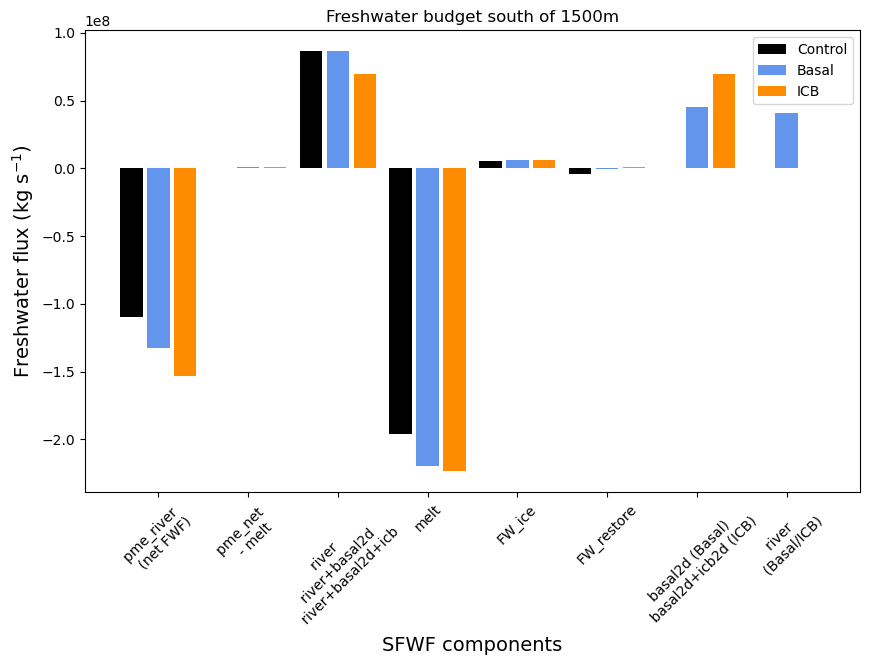

In [34]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,6))
# pme_river = pme_net + river
pyplot.bar(-.3, pme_river_annual_hint_shelf_ctrl, width=0.25, color='k', label='Control')
pyplot.bar(0, pme_river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG, width=0.25, color='cornflowerblue', label='Basal')
pyplot.bar(0.3, pme_river_annual_hint_shelf_ICB+(basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB), width=0.25, color='darkorange', label='ICB')
plt.legend()

# test with pme_net - melt
pyplot.bar(0.7, pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl, width=0.25, color='k')
pyplot.bar(1, pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(1.3, pme_net_annual_hint_shelf_ICB - melt_annual_hint_shelf_ICB, width=0.25, color='darkorange')

pyplot.bar(1.7, river_annual_hint_shelf_ctrl, width=0.25, color='k')
pyplot.bar(2, river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(2.3, river_annual_hint_shelf_ICB + basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB, width=0.25, color='darkorange')

# pme_net includes melt!
pyplot.bar(2.7, melt_annual_hint_shelf_ctrl, width=0.25, color='k')
pyplot.bar(3, melt_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(3.3, melt_annual_hint_shelf_ICB, width=0.25, color='darkorange')

pyplot.bar(3.7, FW_ice_annual_hint_shelf_ctrl, width=0.25, color='k')
pyplot.bar(4, FW_ice_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(4.3, FW_ice_annual_hint_shelf_ICB, width=0.25, color='darkorange')

pyplot.bar(4.7, FW_restore_annual_hint_shelf_ctrl, width=0.25, color='k')
pyplot.bar(5, FW_restore_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(5.3, FW_restore_annual_hint_shelf_ICB, width=0.25, color='darkorange')

# pyplot.bar(4.7, basal_annual_hint_shelf_noBG, width=0.25, color='lightbluek')
pyplot.bar(6., basal_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(6.3, basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB, width=0.25, color='darkorange')

pyplot.bar(7., river_annual_hint_shelf_BG, width=0.25, color='cornflowerblue')
pyplot.bar(7.3, river_annual_hint_shelf_ICB, width=0.25, color='darkorange')

# ax.set_xticks(np.arange(0,5),('pme_river \n (net FWF)','pme \n =(pme_net - melt)','river \n river+basal2d \n river+basal2d+icb','melt',
#                               'basal2d (Basal) \n basal2d+icb2d (ICB)'))
ax.set_xticks(np.arange(0,8),('pme_river \n (net FWF)','pme_net \n - melt','river \n river+basal2d \n river+basal2d+icb','melt',
                              'FW_ice','FW_restore','basal2d (Basal) \n basal2d+icb2d (ICB)','river \n (Basal/ICB)'),rotation=45)
ax.set_xlabel('SFWF components',fontsize=14)
ax.set_ylabel('Freshwater flux (kg s$^{-1}$)',fontsize=14)

plt.title('Freshwater budget south of 1500m')

### Save fig
plt.savefig(figdir+'SFWF_components_annual_hint_shelf_yr10.png')


# final plot, with noBasalGade

In [35]:
# print values for a table:

print(' --- NET ---')
print('Control = ', pme_river_annual_hint_shelf_ctrl*1e-8)
print('BG = ', pme_river_annual_hint_shelf_BG*1e-8)
print('ICB = ', pme_river_annual_hint_shelf_ICB*1e-8)
print('noBG = ', pme_river_annual_hint_shelf_noBG*1e-8)
print('BGB = ', pme_river_annual_hint_shelf_BGB*1e-8)

print(' --- PME ---')
print('Control = ', (pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl)*1e-8)
print('BG = ', (pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG)*1e-8)
print('ICB = ', (pme_net_annual_hint_shelf_ICB - melt_annual_hint_shelf_ICB)*1e-8)
print('noBG = ', (pme_net_annual_hint_shelf_noBG - melt_annual_hint_shelf_noBG)*1e-8)
print('BGB = ', (pme_net_annual_hint_shelf_BGB - melt_annual_hint_shelf_BGB)*1e-8)

print(' --- RUNOFF (TOTAL) ---')
print('Control = ', river_annual_hint_shelf_ctrl*1e-8)
print('BG = ', (river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG)*1e-8)
print('ICB = ', (river_annual_hint_shelf_ICB + basal_annual_hint_shelf_ICB + icb_annual_hint_shelf_ICB)*1e-8)
print('noBG = ', (river_annual_hint_shelf_noBG + basal_annual_hint_shelf_noBG)*1e-8)
print('BGB = ', (river_annual_hint_shelf_BGB + basal_annual_hint_shelf_BGB)*1e-8)
print(' --- RUNOFF basal/icb only ---')
print('BG = ', basal_annual_hint_shelf_BG*1e-8)
print('ICB = ', (basal_annual_hint_shelf_ICB + icb_annual_hint_shelf_ICB)*1e-8)
print('noBG = ', basal_annual_hint_shelf_noBG*1e-8)
print('BGb = ', basal_annual_hint_shelf_BGB*1e-8)

print(' --- SEA-ICE ---')
print('Control = ', melt_annual_hint_shelf_ctrl*1e-8)
print('BG = ', melt_annual_hint_shelf_BG*1e-8)
print('ICB = ', melt_annual_hint_shelf_ICB*1e-8)
print('noBG = ', melt_annual_hint_shelf_noBG*1e-8)
print('BGB = ', melt_annual_hint_shelf_BGB*1e-8)

print(' --- SEA-ICE FORM. ---')
print('Control = ', wfiform_annual_hint_shelf_ctrl*1e-8)
print('BG = ', wfiform_annual_hint_shelf_BG*1e-8)
print('ICB = ', wfiform_annual_hint_shelf_ICB*1e-8)
print('noBG = ', wfiform_annual_hint_shelf_noBG*1e-8)
print('BGB = ', wfiform_annual_hint_shelf_BGB*1e-8)

print(' --- SEA-ICE MELT ---')
print('Control = ', wfimelt_annual_hint_shelf_ctrl*1e-8)
print('BG = ', wfimelt_annual_hint_shelf_BG*1e-8)
print('ICB = ', wfimelt_annual_hint_shelf_ICB*1e-8)
print('noBG = ', wfimelt_annual_hint_shelf_noBG*1e-8)
print('BGB = ', wfimelt_annual_hint_shelf_BGB*1e-8)

print(' --- FWF SEA-ICE ---')
print('Control = ', FW_ice_annual_hint_shelf_ctrl*1e-8)
print('BG = ', FW_ice_annual_hint_shelf_BG*1e-8)
print('ICB = ', FW_ice_annual_hint_shelf_ICB*1e-8)
print('noBG = ', FW_ice_annual_hint_shelf_noBG*1e-8)
print('BGB = ', FW_ice_annual_hint_shelf_BGB*1e-8)

print(' --- FWF RESTORE ---')
print('Control = ', FW_restore_annual_hint_shelf_ctrl*1e-8)
print('BG = ', FW_restore_annual_hint_shelf_BG*1e-8)
print('ICB = ', FW_restore_annual_hint_shelf_ICB*1e-8)
print('noBG = ', FW_restore_annual_hint_shelf_noBG*1e-8)
print('BGB = ', FW_restore_annual_hint_shelf_BGB*1e-8)


 --- NET ---
Control =  -1.09415408
BG =  -1.7801248
ICB =  -2.2281216
noBG =  -1.50406688
BGB =  1.5289363200000001
 --- PME ---
Control =  0.0058272
BG =  0.00701968
ICB =  0.00776592
noBG =  0.00454656
BGB =  3.26919392
 --- RUNOFF (TOTAL) ---
Control =  0.86390448
BG =  0.8639032
ICB =  0.69282744
noBG =  0.8639048
BGB =  0.41075368
 --- RUNOFF basal/icb only ---
BG =  0.45314952000000003
ICB =  0.69282744
noBG =  0.45315116
BGb =  0.0
 --- SEA-ICE ---
Control =  -1.9638857600000001
BG =  -2.1978982400000002
ICB =  -2.23588752
noBG =  -1.91936704
BGB =  -2.1510112
 --- SEA-ICE FORM. ---
Control =  -2.89225824
BG =  -3.38446656
ICB =  -3.43772128
noBG =  -2.83397632
BGB =  -3.2587904
 --- SEA-ICE MELT ---
Control =  0.92837248
BG =  1.18656864
ICB =  1.2018336
noBG =  0.91460928
BGB =  1.10777936
 --- FWF SEA-ICE ---
Control =  0.05389004
BG =  0.05985276
ICB =  0.06084833
noBG =  0.05281952
BGB =  0.058667935000000004
 --- FWF RESTORE ---
Control =  -0.04300972
BG =  -0.00624487062

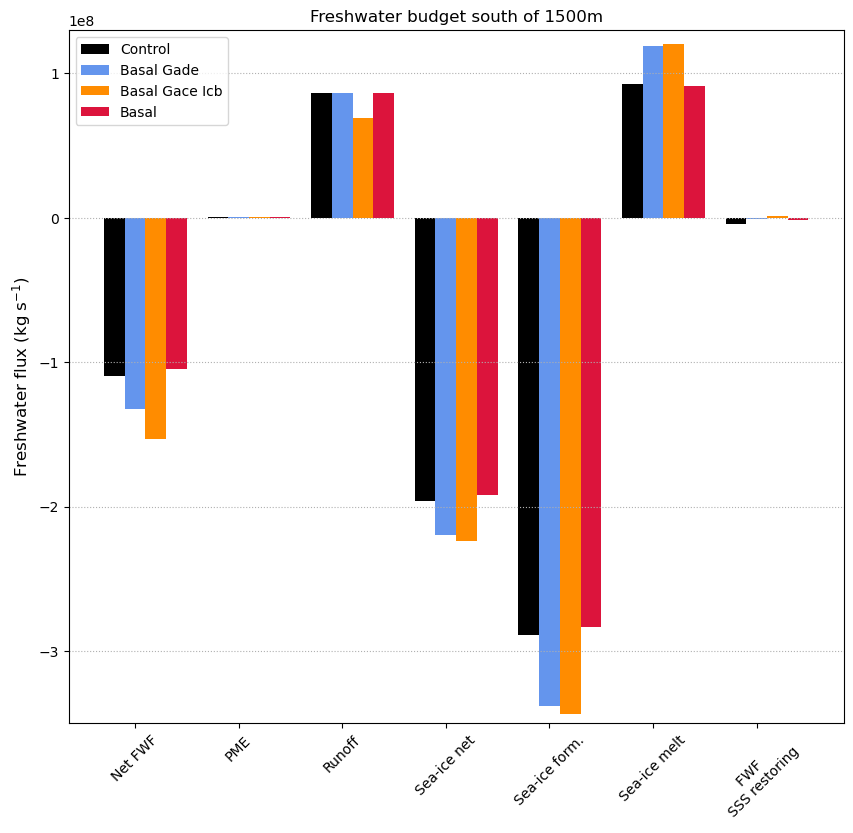

In [37]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,9))
# pme_river = pme_net + river +basal2d+icb2d
pyplot.bar(-.2, pme_river_annual_hint_shelf_ctrl, width=0.2, color='k', label='Control')
pyplot.bar(0, pme_river_annual_hint_shelf_BG+ basal_annual_hint_shelf_BG, width=0.2, color='cornflowerblue', label='Basal Gade')
pyplot.bar(0.2, pme_river_annual_hint_shelf_ICB+(basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB), width=0.2, color='darkorange', label='Basal Gace Icb')
pyplot.bar(0.4, pme_river_annual_hint_shelf_noBG+ basal_annual_hint_shelf_noBG, width=0.2, color='crimson', label='Basal')
plt.legend()

# test with pme_net - melt
pyplot.bar(0.8, pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(1, pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(1.2, pme_net_annual_hint_shelf_ICB - melt_annual_hint_shelf_ICB, width=0.2, color='darkorange')
pyplot.bar(1.4, pme_net_annual_hint_shelf_noBG - melt_annual_hint_shelf_noBG, width=0.2, color='crimson')

pyplot.bar(1.8, river_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(2, river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(2.2, river_annual_hint_shelf_ICB + basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB, width=0.2, color='darkorange')
pyplot.bar(2.4, river_annual_hint_shelf_noBG + basal_annual_hint_shelf_noBG, width=0.2, color='crimson')

# pme_net includes melt!
pyplot.bar(2.8, melt_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(3, melt_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(3.2, melt_annual_hint_shelf_ICB, width=0.2, color='darkorange')
pyplot.bar(3.4, melt_annual_hint_shelf_noBG, width=0.2, color='crimson')

pyplot.bar(3.8, wfiform_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(4, wfiform_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(4.2, wfiform_annual_hint_shelf_ICB, width=0.2, color='darkorange')
pyplot.bar(4.4, wfiform_annual_hint_shelf_noBG, width=0.2, color='crimson')

pyplot.bar(4.8, wfimelt_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(5, wfimelt_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(5.2, wfimelt_annual_hint_shelf_ICB, width=0.2, color='darkorange')
pyplot.bar(5.4, wfimelt_annual_hint_shelf_noBG, width=0.2, color='crimson')

# pyplot.bar(5.8, FW_ice_annual_hint_shelf_ctrl, width=0.2, color='k')
# pyplot.bar(6, FW_ice_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
# pyplot.bar(6.2, FW_ice_annual_hint_shelf_ICB, width=0.2, color='darkorange')
# pyplot.bar(6.4, FW_ice_annual_hint_shelf_noBG, width=0.2, color='crimson')

pyplot.bar(5.8, FW_restore_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(6, FW_restore_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(6.2, FW_restore_annual_hint_shelf_ICB, width=0.2, color='darkorange')
pyplot.bar(6.4, FW_restore_annual_hint_shelf_noBG, width=0.2, color='crimson')

# pyplot.bar(6., basal_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
# pyplot.bar(6.2, basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB, width=0.2, color='darkorange')
# pyplot.bar(6.4, basal_annual_hint_shelf_noBG, width=0.2, color='crimson')

ax.set_xticks(np.arange(0,7),('Net FWF','PME','Runoff','Sea-ice net','Sea-ice form.','Sea-ice melt',
                              'FWF \n SSS restoring'),rotation=45) #'FWF \n sea ice',
# ax.set_xlabel('SFWF components',fontsize=14)
ax.set_ylabel('Freshwater flux (kg s$^{-1}$)',fontsize=12)
ax.set_ylim(-3.5e8,1.3e8)
ax.yaxis.grid(True, linestyle=':')

plt.title('Freshwater budget south of 1500m')
### Save fig
plt.savefig(figdir+'SFWF_components_annual_hint_shelf_yr10_BGxNoBGxICB.png')



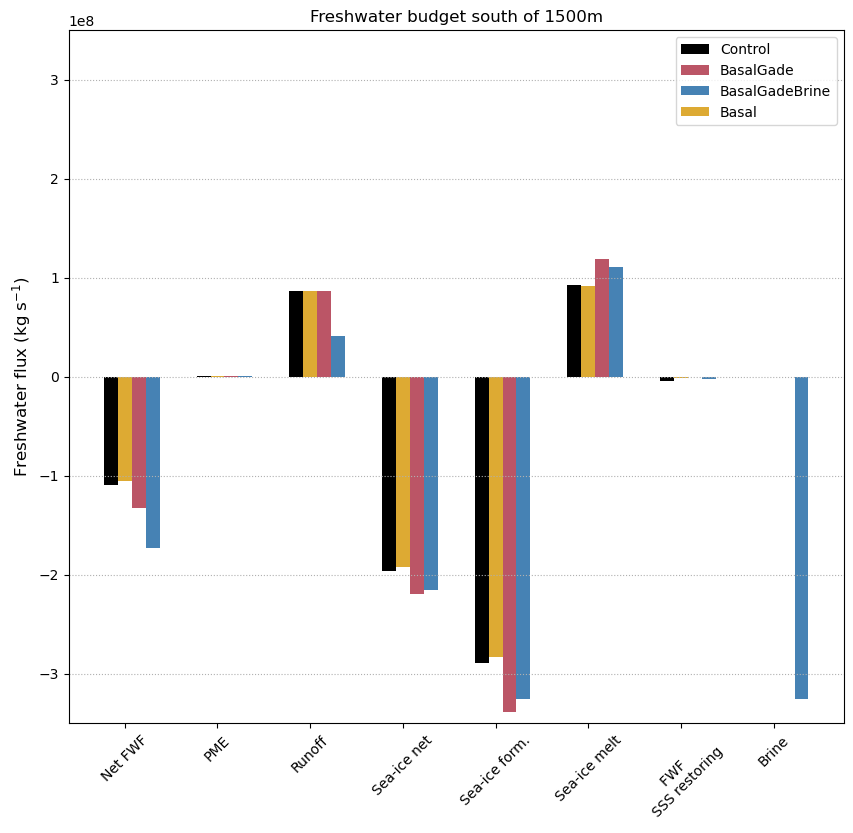

In [38]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,9))
# pme_river = pme_net + river +basal2d+icb2d
pyplot.bar(-.15, pme_river_annual_hint_shelf_ctrl, width=0.15, color='k', label='Control')
pyplot.bar(0.15, pme_river_annual_hint_shelf_BG+ basal_annual_hint_shelf_BG, width=0.15, color='#BB5566', label='BasalGade')
pyplot.bar(0.3, pme_river_annual_hint_shelf_BGB+(basal_annual_hint_shelf_BGB)+ brine_annual_hint_shelf_BGB, width=0.15, color='steelblue', label='BasalGadeBrine')
pyplot.bar(0., pme_river_annual_hint_shelf_noBG+ basal_annual_hint_shelf_noBG, width=0.15, color='#DDAA33', label='Basal')
plt.legend()

# test with pme_net - melt
pyplot.bar(0.85, pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(1.15, pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(1.3, pme_net_annual_hint_shelf_BGB - melt_annual_hint_shelf_BGB+ brine_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(1., pme_net_annual_hint_shelf_noBG - melt_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(1.85, river_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(2.15, river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(2.3, river_annual_hint_shelf_BGB + basal_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(2., river_annual_hint_shelf_noBG + basal_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

# pme_net includes melt!
pyplot.bar(2.85, melt_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(3.15, melt_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(3.3, melt_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(3., melt_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(3.85, wfiform_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(4.15, wfiform_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(4.3, wfiform_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(4., wfiform_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(4.85, wfimelt_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(5.15, wfimelt_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(5.3, wfimelt_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(5., wfimelt_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(5.85, FW_restore_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(6.15, FW_restore_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(6.3, FW_restore_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(6., FW_restore_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(7.3, brine_annual_hint_shelf_BGB, width=0.15, color='steelblue')

ax.set_xticks(np.arange(0,8),('Net FWF','PME','Runoff','Sea-ice net','Sea-ice form.','Sea-ice melt',
                              'FWF \n SSS restoring','Brine'),rotation=45) #'FWF \n sea ice',
# ax.set_xlabel('SFWF components',fontsize=14)
ax.set_ylabel('Freshwater flux (kg s$^{-1}$)',fontsize=12)
ax.set_ylim(-3.5e8,3.5e8)
ax.yaxis.grid(True, linestyle=':')

plt.title('Freshwater budget south of 1500m')

### Save fig
plt.savefig(figdir+'SFWF_components_annual_hint_shelf_yr10_FinalFig.png')


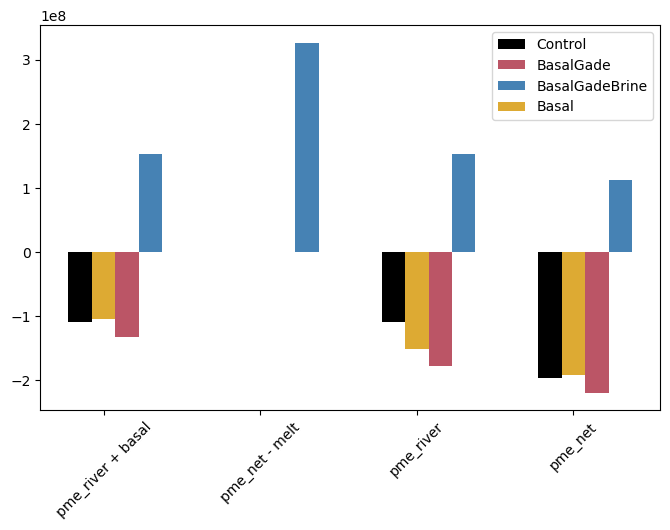

In [44]:
fig, ax  = plt.subplots(figsize = (8,5))
# pme_river = pme_net + river +basal2d+icb2d
pyplot.bar(-.15, pme_river_annual_hint_shelf_ctrl, width=0.15, color='k', label='Control')
pyplot.bar(0.15, pme_river_annual_hint_shelf_BG+ basal_annual_hint_shelf_BG, width=0.15, color='#BB5566', label='BasalGade')
pyplot.bar(0.3, pme_river_annual_hint_shelf_BGB+(basal_annual_hint_shelf_BGB), width=0.15, color='steelblue', label='BasalGadeBrine')
pyplot.bar(0., pme_river_annual_hint_shelf_noBG+ basal_annual_hint_shelf_noBG, width=0.15, color='#DDAA33', label='Basal')
plt.legend()

# test with pme_net - melt
pyplot.bar(0.85, pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(1.15, pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(1.3, pme_net_annual_hint_shelf_BGB - melt_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(1., pme_net_annual_hint_shelf_noBG - melt_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(1.85, pme_river_annual_hint_shelf_ctrl, width=0.15, color='k')#, label='Control')
pyplot.bar(2.15, pme_river_annual_hint_shelf_BG , width=0.15, color='#BB5566')#, label='BasalGade')
pyplot.bar(2.3, pme_river_annual_hint_shelf_BGB, width=0.15, color='steelblue')#, label='BasalGadeBrine')
pyplot.bar(2., pme_river_annual_hint_shelf_noBG , width=0.15, color='#DDAA33')#, label='Basal')

# test with pme_net - melt
pyplot.bar(2.85, pme_net_annual_hint_shelf_ctrl , width=0.15, color='k')
pyplot.bar(3.15, pme_net_annual_hint_shelf_BG , width=0.15, color='#BB5566')
pyplot.bar(3.3, pme_net_annual_hint_shelf_BGB , width=0.15, color='steelblue')
pyplot.bar(3., pme_net_annual_hint_shelf_noBG , width=0.15, color='#DDAA33')

ax.set_xticks(np.arange(0,4),('pme_river + basal','pme_net - melt','pme_river','pme_net'),rotation=45)

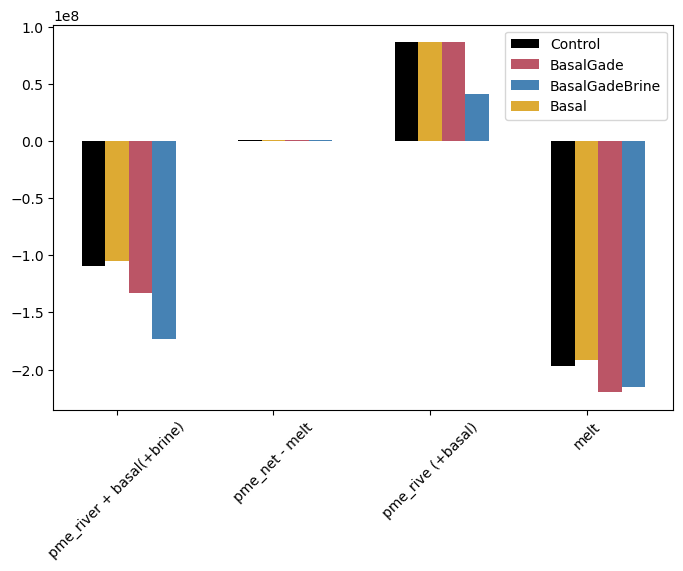

In [42]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (8,5))
# pme_river = pme_net + river +basal2d+icb2d
pyplot.bar(-.15, pme_river_annual_hint_shelf_ctrl, width=0.15, color='k', label='Control')
pyplot.bar(0.15, pme_river_annual_hint_shelf_BG+ basal_annual_hint_shelf_BG, width=0.15, color='#BB5566', label='BasalGade')
pyplot.bar(0.3, pme_river_annual_hint_shelf_BGB+(basal_annual_hint_shelf_BGB)+ brine_annual_hint_shelf_BGB, width=0.15, color='steelblue', label='BasalGadeBrine')
pyplot.bar(0., pme_river_annual_hint_shelf_noBG+ basal_annual_hint_shelf_noBG, width=0.15, color='#DDAA33', label='Basal')
plt.legend()

# test with pme_net - melt
pyplot.bar(0.85, pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(1.15, pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(1.3, pme_net_annual_hint_shelf_BGB - melt_annual_hint_shelf_BGB+ brine_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(1., pme_net_annual_hint_shelf_noBG - melt_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

pyplot.bar(1.85, river_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(2.15, river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(2.3, river_annual_hint_shelf_BGB + basal_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(2., river_annual_hint_shelf_noBG + basal_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

# pme_net includes melt!
pyplot.bar(2.85, melt_annual_hint_shelf_ctrl, width=0.15, color='k')
pyplot.bar(3.15, melt_annual_hint_shelf_BG, width=0.15, color='#BB5566')
pyplot.bar(3.3, melt_annual_hint_shelf_BGB, width=0.15, color='steelblue')
pyplot.bar(3., melt_annual_hint_shelf_noBG, width=0.15, color='#DDAA33')

ax.set_xticks(np.arange(0,4),('pme_river + basal(+brine)','pme_net - melt','pme_rive (+basal)','melt'),rotation=45)

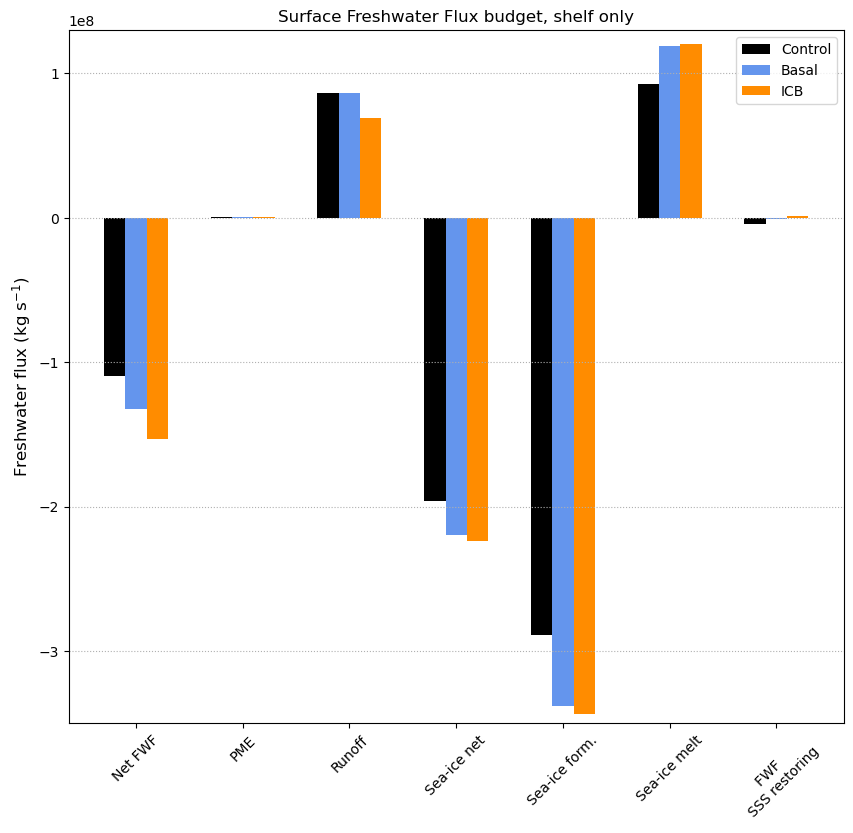

In [33]:
# plot with bars: last year annual avg, horizontally-integrated (over the shelf , depth<1000m only):
fig, ax  = plt.subplots(figsize = (10,9))
# pme_river = pme_net + river +basal2d+icb2d
pyplot.bar(-.2, pme_river_annual_hint_shelf_ctrl, width=0.2, color='k', label='Control')
pyplot.bar(0, pme_river_annual_hint_shelf_BG+ basal_annual_hint_shelf_BG, width=0.2, color='cornflowerblue', label='Basal')
pyplot.bar(0.2, pme_river_annual_hint_shelf_ICB+(basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB), width=0.2, color='darkorange', label='ICB')
plt.legend()

# test with pme_net - melt
pyplot.bar(0.8, pme_net_annual_hint_shelf_ctrl - melt_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(1, pme_net_annual_hint_shelf_BG - melt_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(1.2, pme_net_annual_hint_shelf_ICB - melt_annual_hint_shelf_ICB, width=0.2, color='darkorange')

pyplot.bar(1.8, river_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(2, river_annual_hint_shelf_BG + basal_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(2.2, river_annual_hint_shelf_ICB + basal_annual_hint_shelf_ICB+icb_annual_hint_shelf_ICB, width=0.2, color='darkorange')

# pme_net includes melt!
pyplot.bar(2.8, melt_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(3, melt_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(3.2, melt_annual_hint_shelf_ICB, width=0.2, color='darkorange')

pyplot.bar(3.8, wfiform_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(4, wfiform_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(4.2, wfiform_annual_hint_shelf_ICB, width=0.2, color='darkorange')

pyplot.bar(4.8, wfimelt_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(5, wfimelt_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(5.2, wfimelt_annual_hint_shelf_ICB, width=0.2, color='darkorange')


pyplot.bar(5.8, FW_restore_annual_hint_shelf_ctrl, width=0.2, color='k')
pyplot.bar(6, FW_restore_annual_hint_shelf_BG, width=0.2, color='cornflowerblue')
pyplot.bar(6.2, FW_restore_annual_hint_shelf_ICB, width=0.2, color='darkorange')


ax.set_xticks(np.arange(0,7),('Net FWF','PME','Runoff','Sea-ice net','Sea-ice form.','Sea-ice melt',
                              'FWF \n SSS restoring'),rotation=45) 

ax.set_ylabel('Freshwater flux (kg s$^{-1}$)',fontsize=12)
ax.set_ylim(-3.5e8,1.3e8)
ax.yaxis.grid(True, linestyle=':')

plt.title('Surface Freshwater Flux budget, shelf only')

### Save fig
plt.savefig(figdir+'SFWF_components_annual_hint_shelf_yr10_FinalFig_WO_noBG.png')


#### Some map plots below:

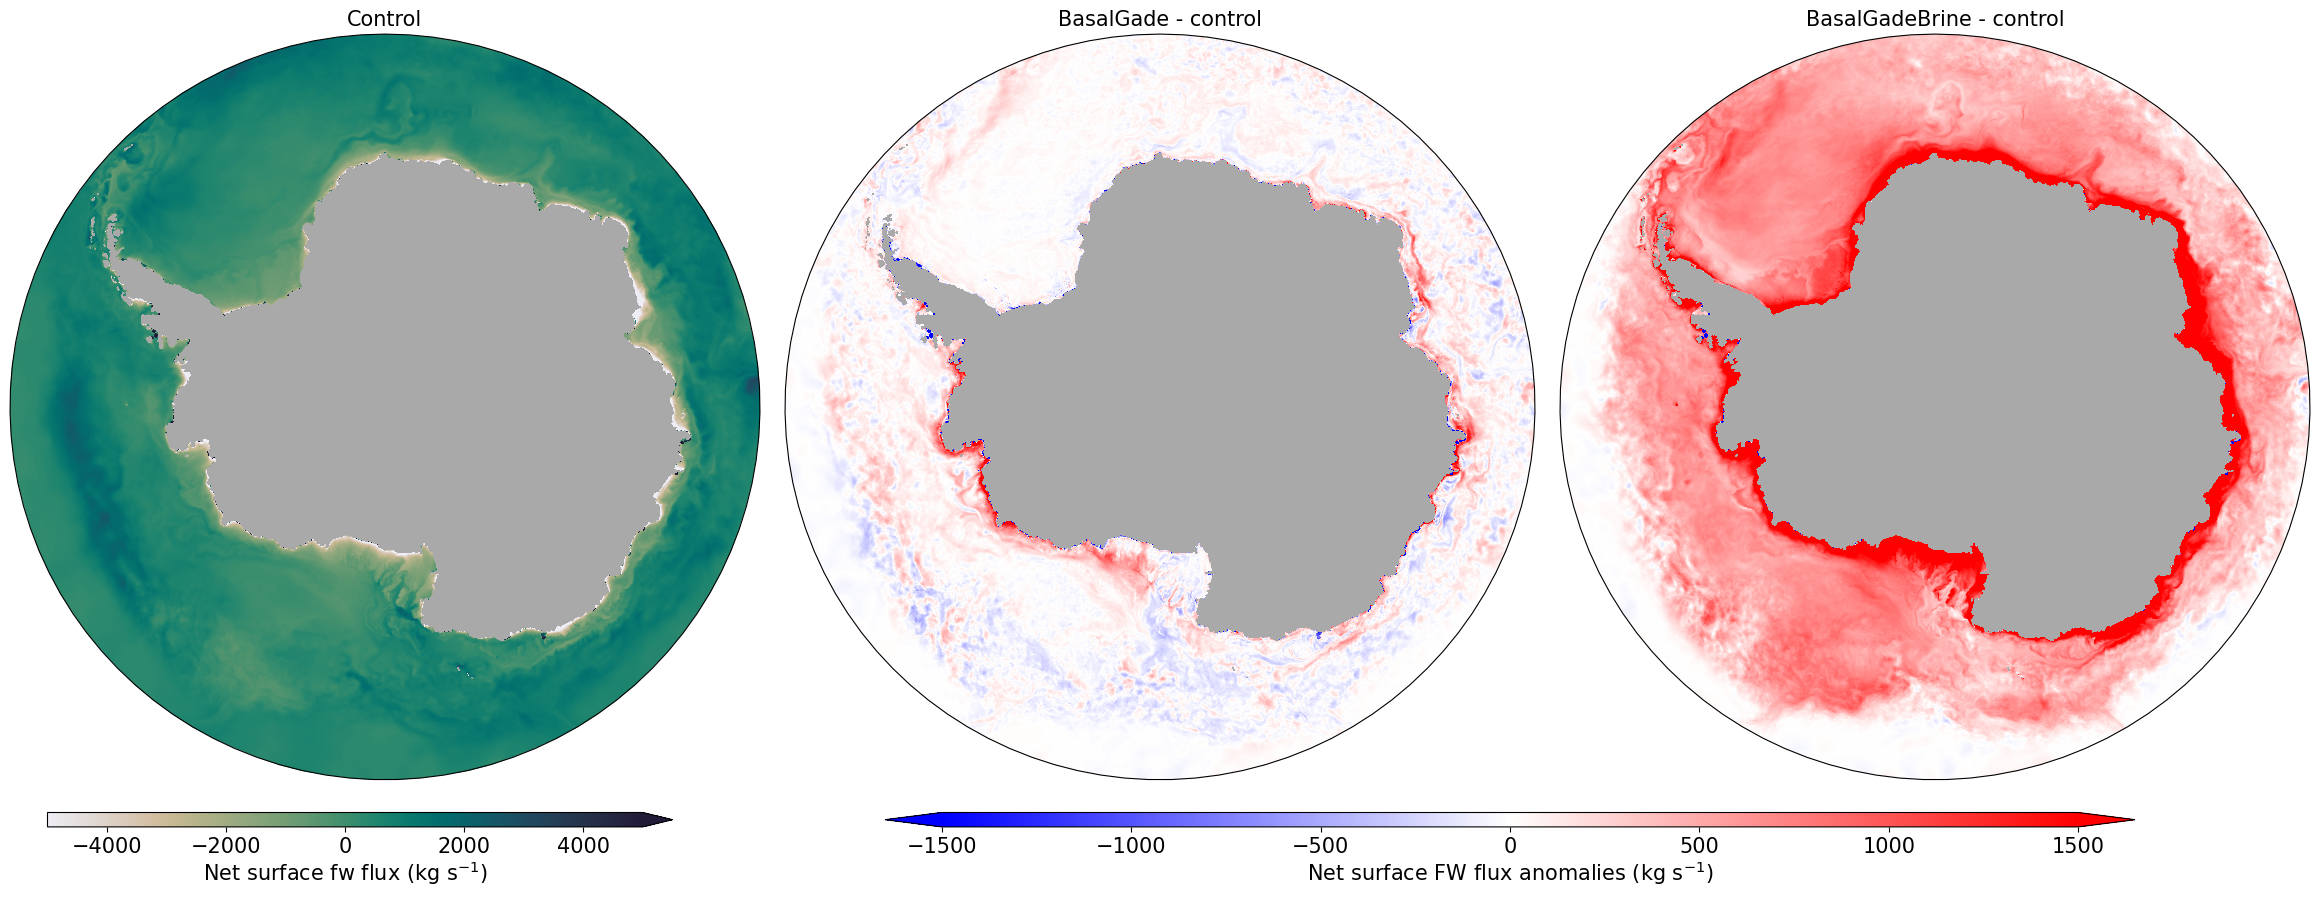

In [52]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-5000
rmax=5000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(pme_river.xt_ocean, pme_river.yt_ocean, pme_river.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-1500
rmax=1500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(pme_river_BG.xt_ocean, pme_river_BG.yt_ocean, pme_river_BG.mean('time')*area_t - pme_river.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGade - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(pme_river_BGB.xt_ocean, pme_river_BGB.yt_ocean, (pme_river_BGB.mean('time')*area_t + brine_BGB.mean('time')) - pme_river.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGadeBrine - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Net surface fw flux (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Net surface FW flux anomalies (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'pme_river_BG_BGB_anom_y'+str(year)+'.png')

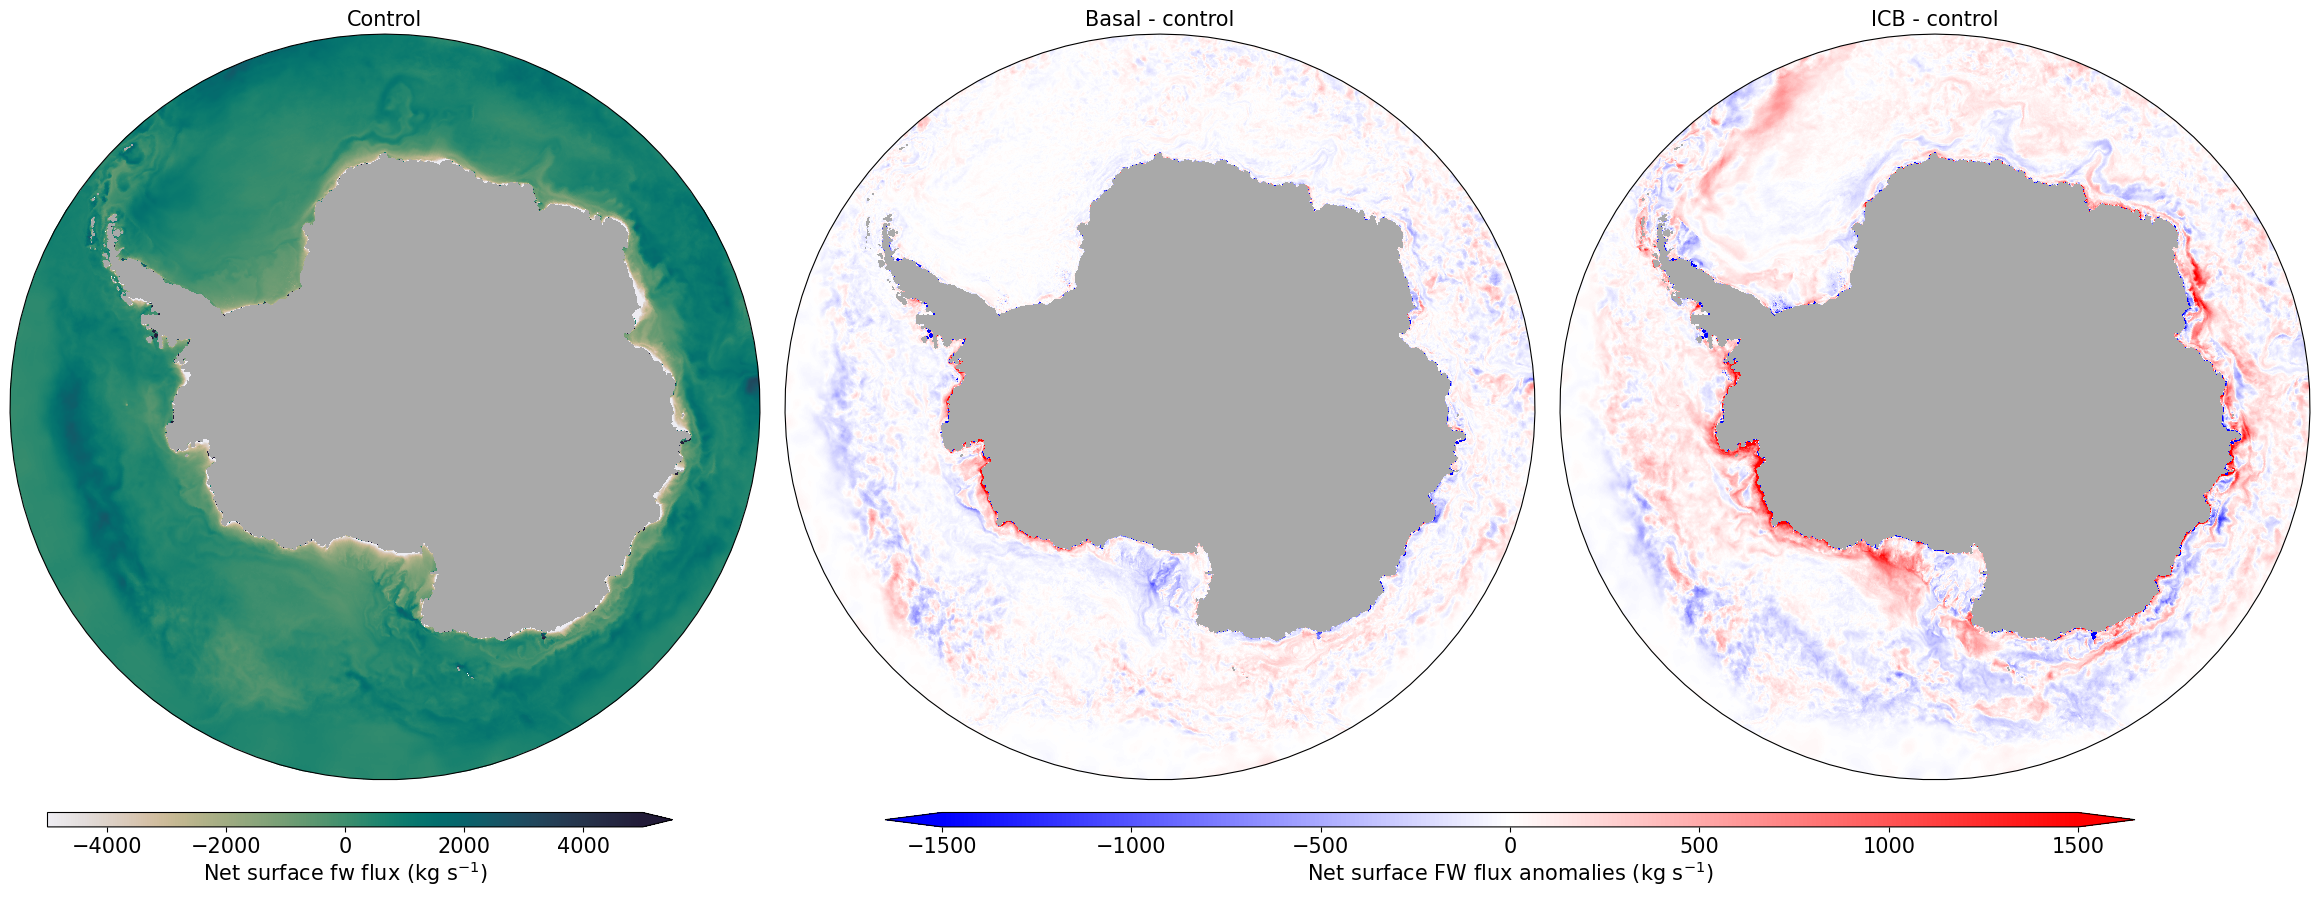

In [50]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-5000
rmax=5000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(pme_river.xt_ocean, pme_river.yt_ocean, pme_river.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-1500
rmax=1500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(pme_river_noBG.xt_ocean, pme_river_noBG.yt_ocean, pme_river_noBG.mean('time')*area_t - pme_river.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(pme_river_ICB.xt_ocean, pme_river_ICB.yt_ocean, pme_river_ICB.mean('time')*area_t - pme_river.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Net surface fw flux (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Net surface FW flux anomalies (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'pme_river_noBG_ICB_anom_y'+str(year)+'.png')

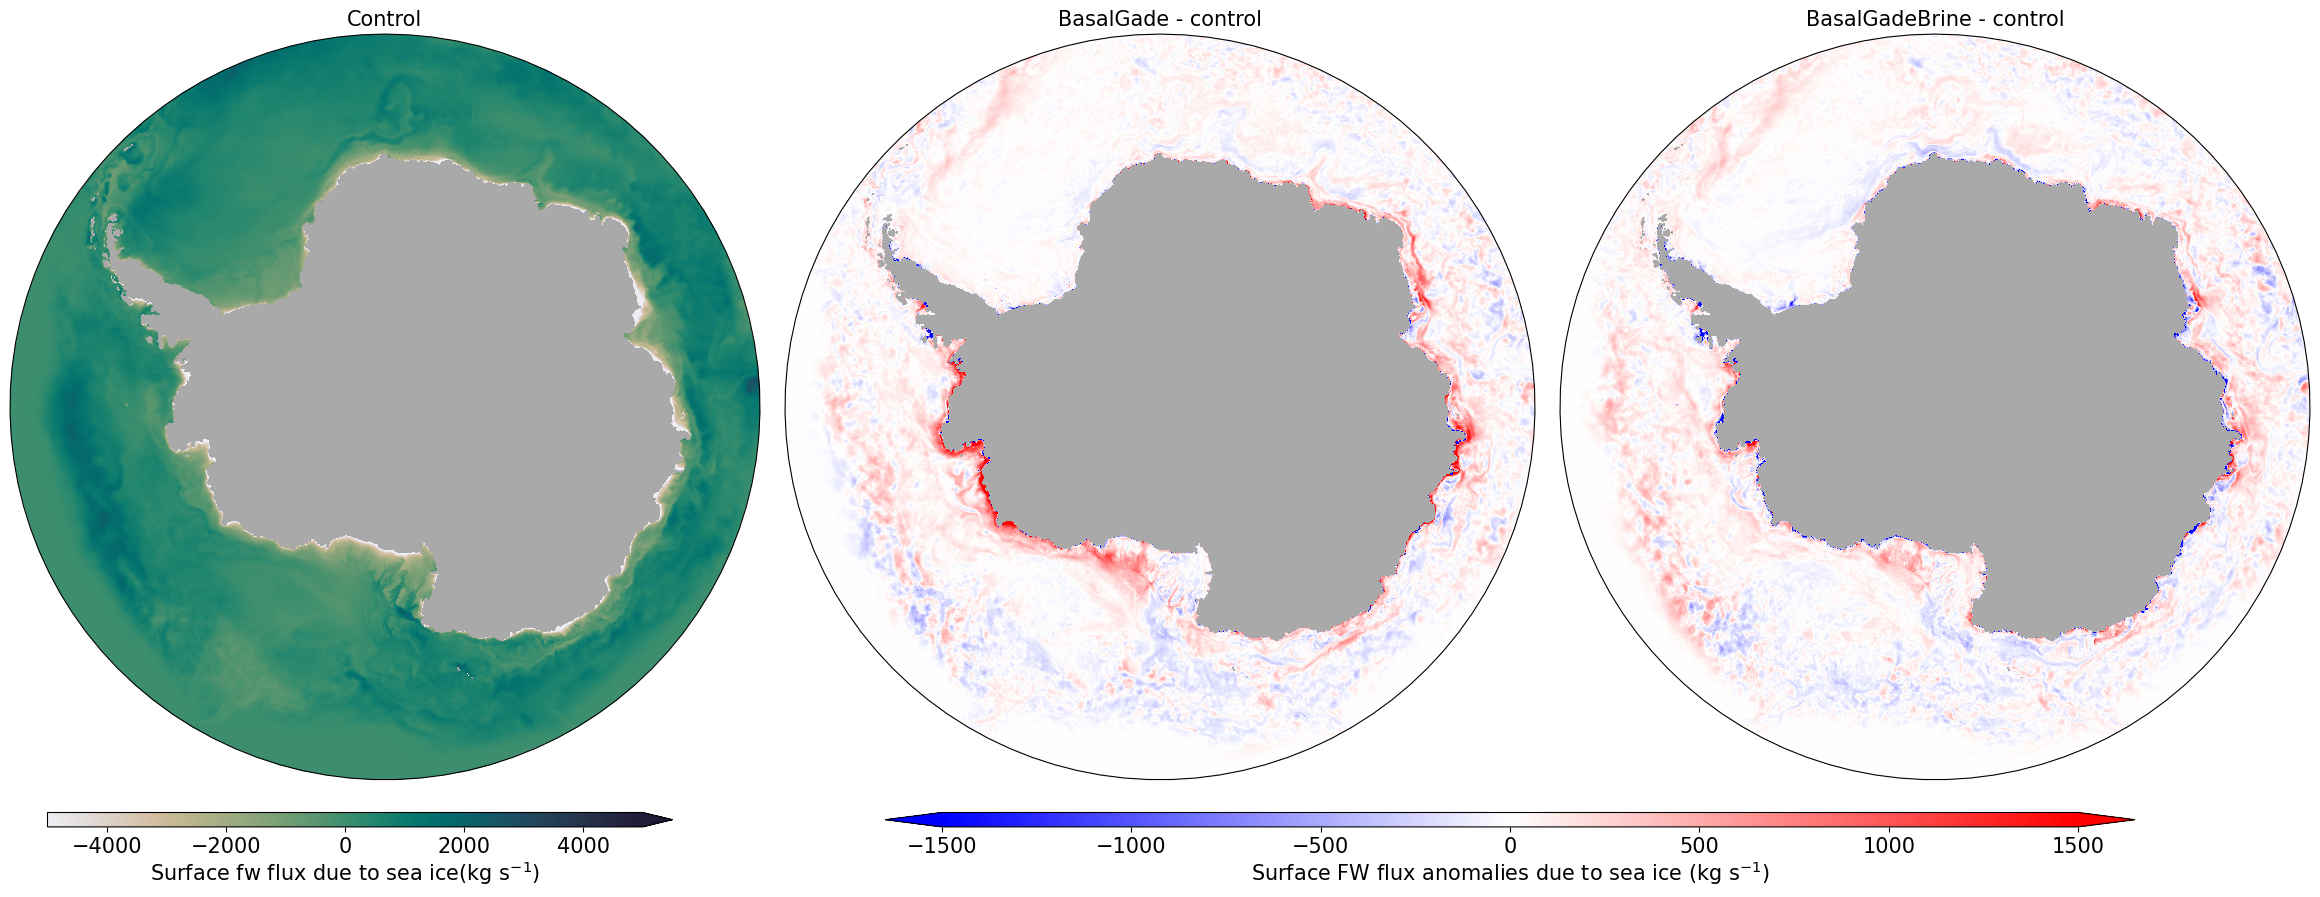

In [53]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-5000
rmax=5000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(melt.xt_ocean, melt.yt_ocean, melt.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-1500
rmax=1500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(melt_BG.xt_ocean, melt_BG.yt_ocean, melt_BG.mean('time')*area_t - melt.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGade - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(melt_BGB.xt_ocean, melt_BGB.yt_ocean, melt_BGB.mean('time')*area_t - melt.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGadeBrine - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface fw flux due to sea ice(kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface FW flux anomalies due to sea ice (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'melt_anom_BG_BGB_y'+str(year)+'.png')

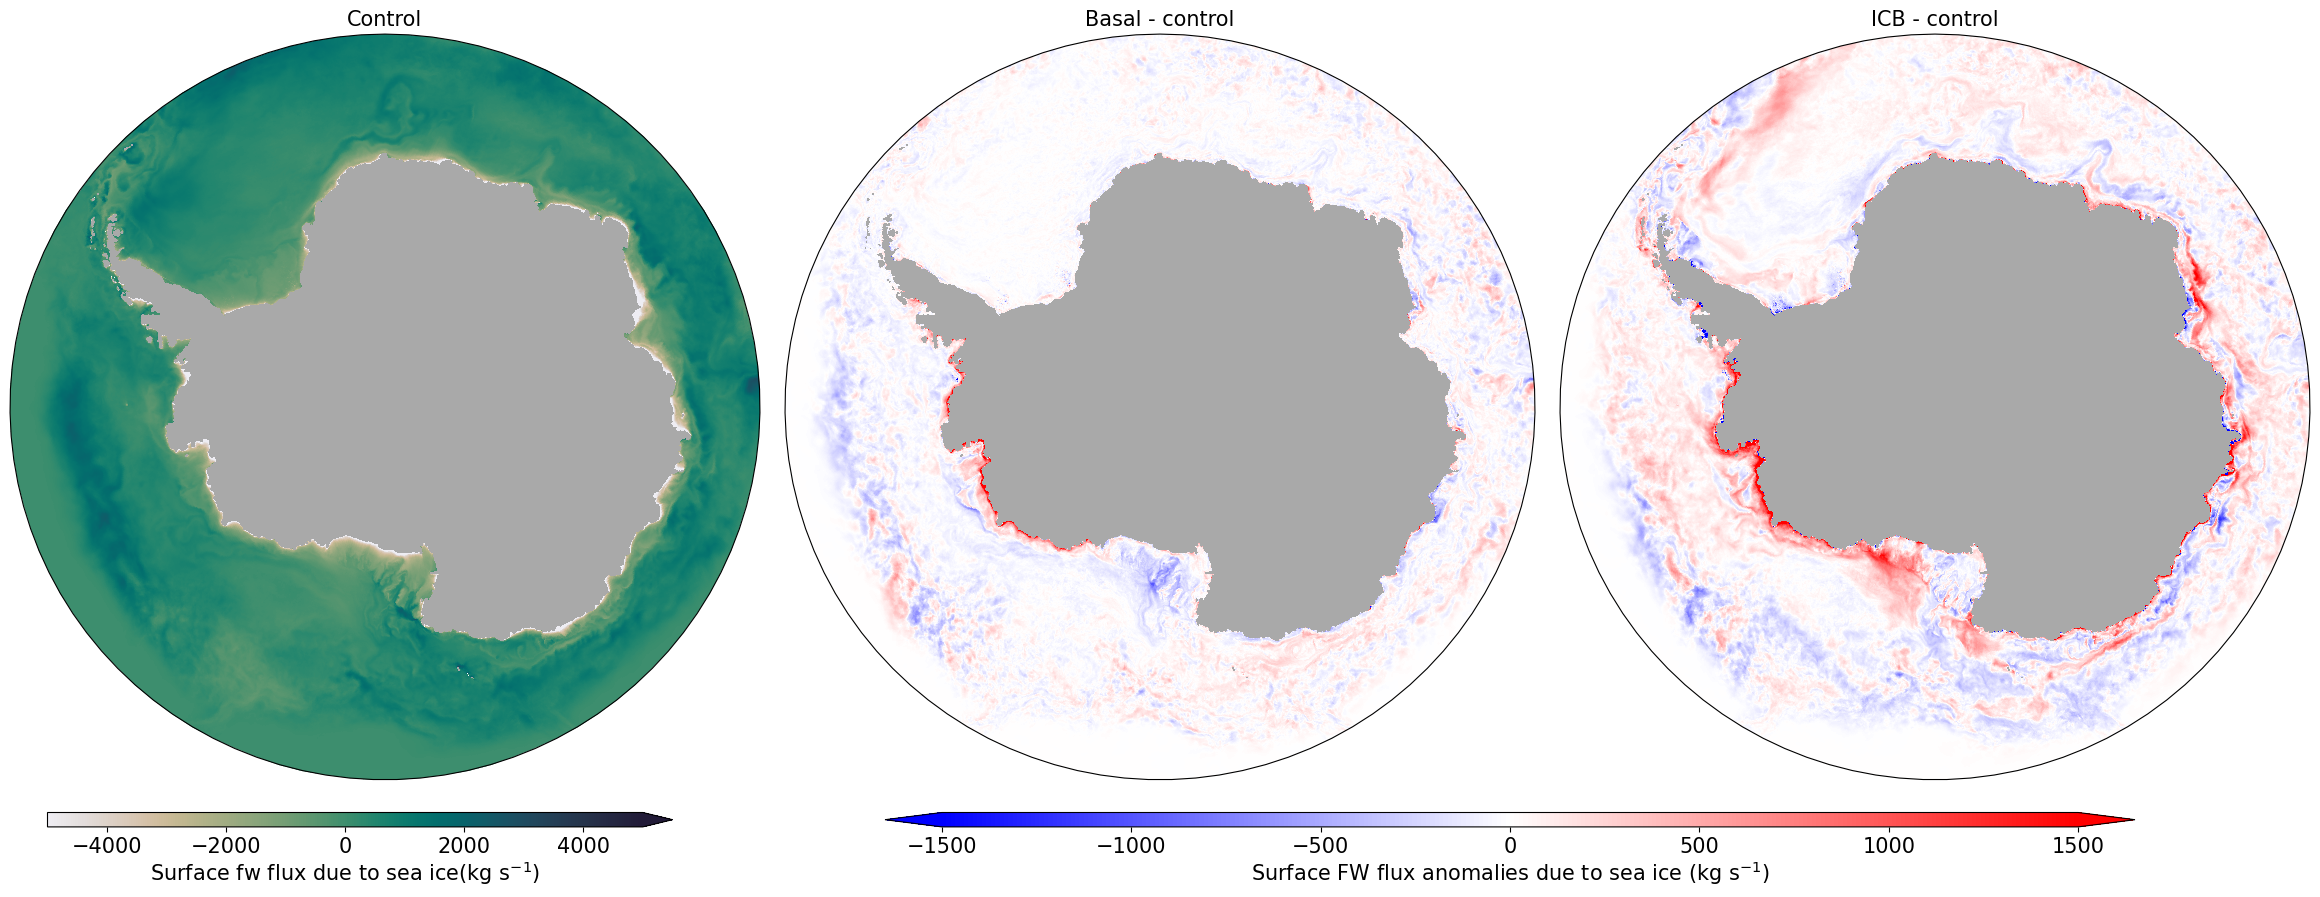

In [54]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-5000
rmax=5000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(melt.xt_ocean, melt.yt_ocean, melt.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-1500
rmax=1500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(melt_noBG.xt_ocean, melt_noBG.yt_ocean, melt_noBG.mean('time')*area_t - melt.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(melt_ICB.xt_ocean, melt_ICB.yt_ocean, melt_ICB.mean('time')*area_t - melt.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface fw flux due to sea ice(kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface FW flux anomalies due to sea ice (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'melt_anom_noBG_ICB_y'+str(year)+'.png')

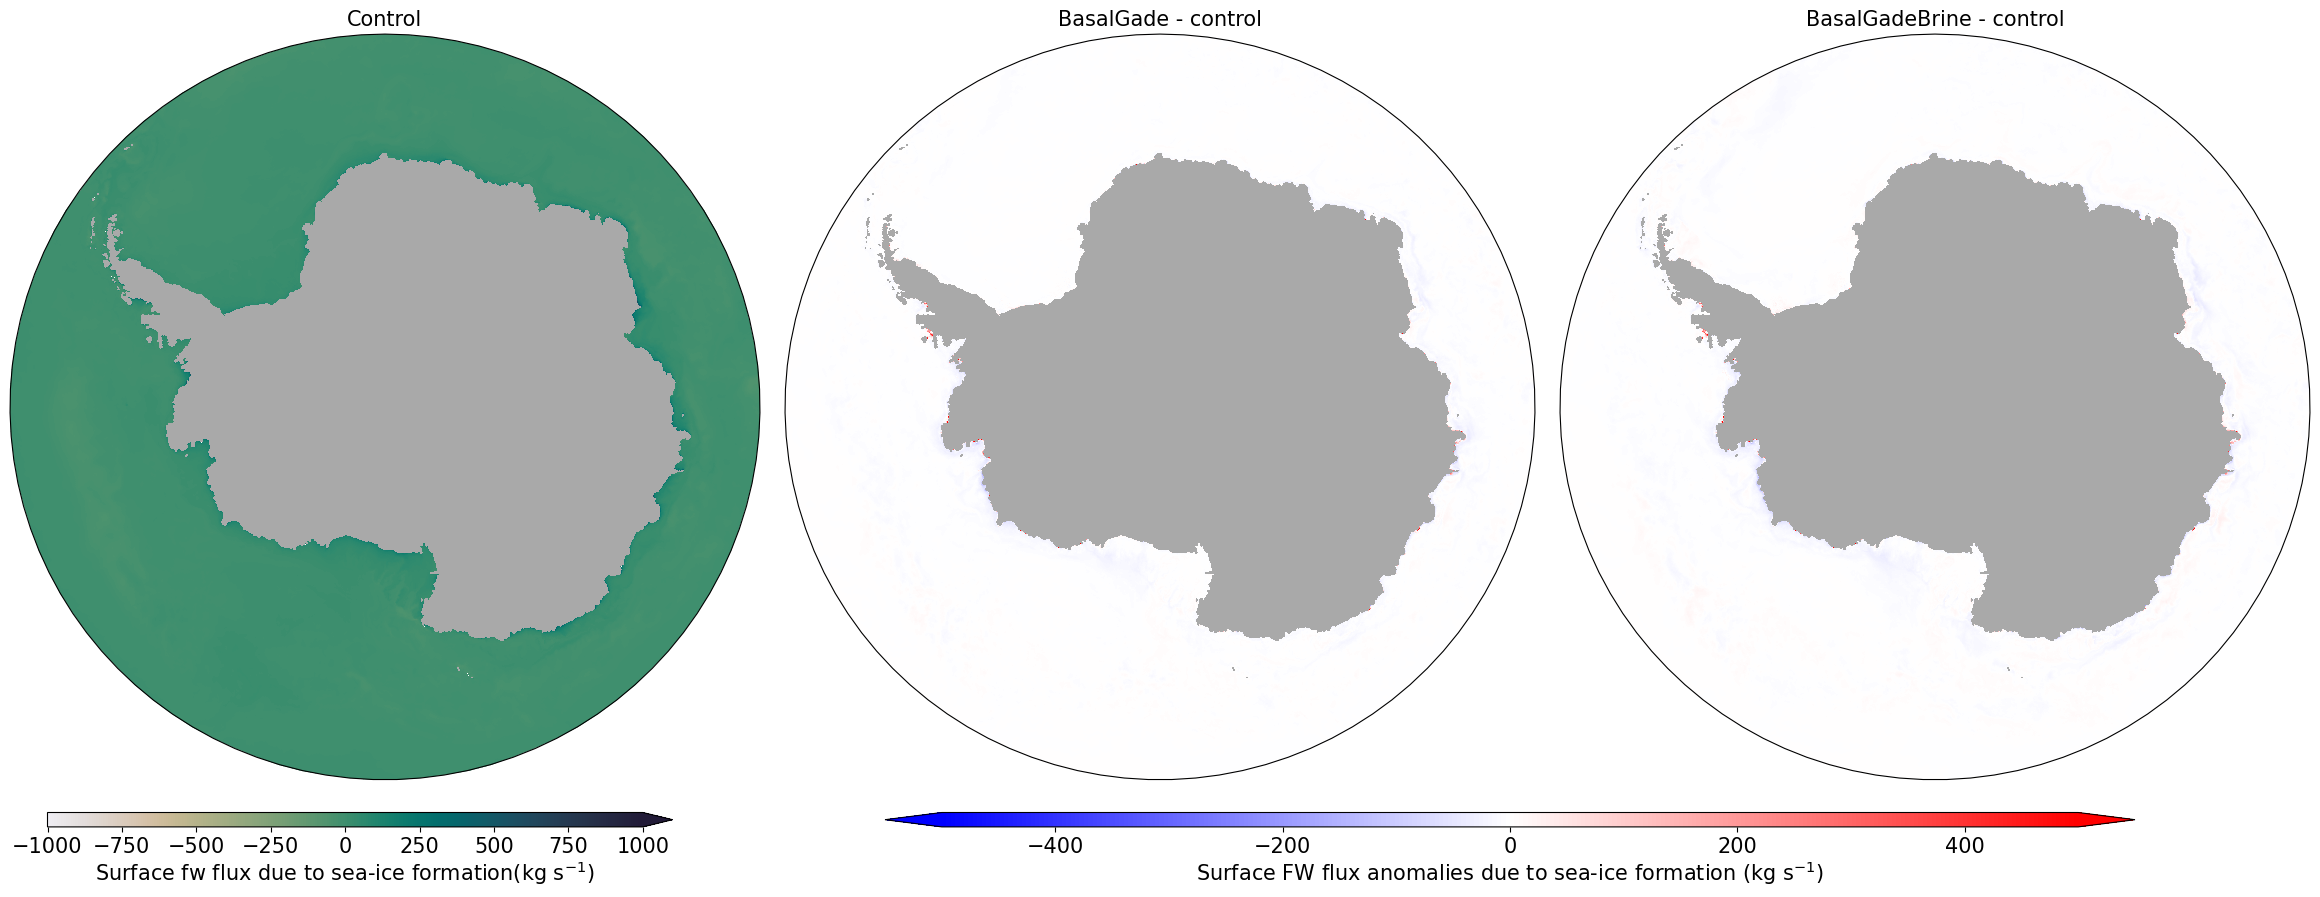

In [57]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-1000
rmax=1000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(FW_ice.xt_ocean, FW_ice.yt_ocean, FW_ice.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-500
rmax=500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(FW_ice_BG.xt_ocean, FW_ice_BG.yt_ocean, FW_ice_BG.mean('time')*area_t - FW_ice.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGade - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(FW_ice_BGB.xt_ocean, FW_ice_ICB.yt_ocean, FW_ice_ICB.mean('time')*area_t - FW_ice.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGadeBrine - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface fw flux due to sea-ice formation(kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface FW flux anomalies due to sea-ice formation (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)


### Save fig
plt.savefig(figdir+'FW_ice_anom_BG_BGB_y'+str(year)+'.png')

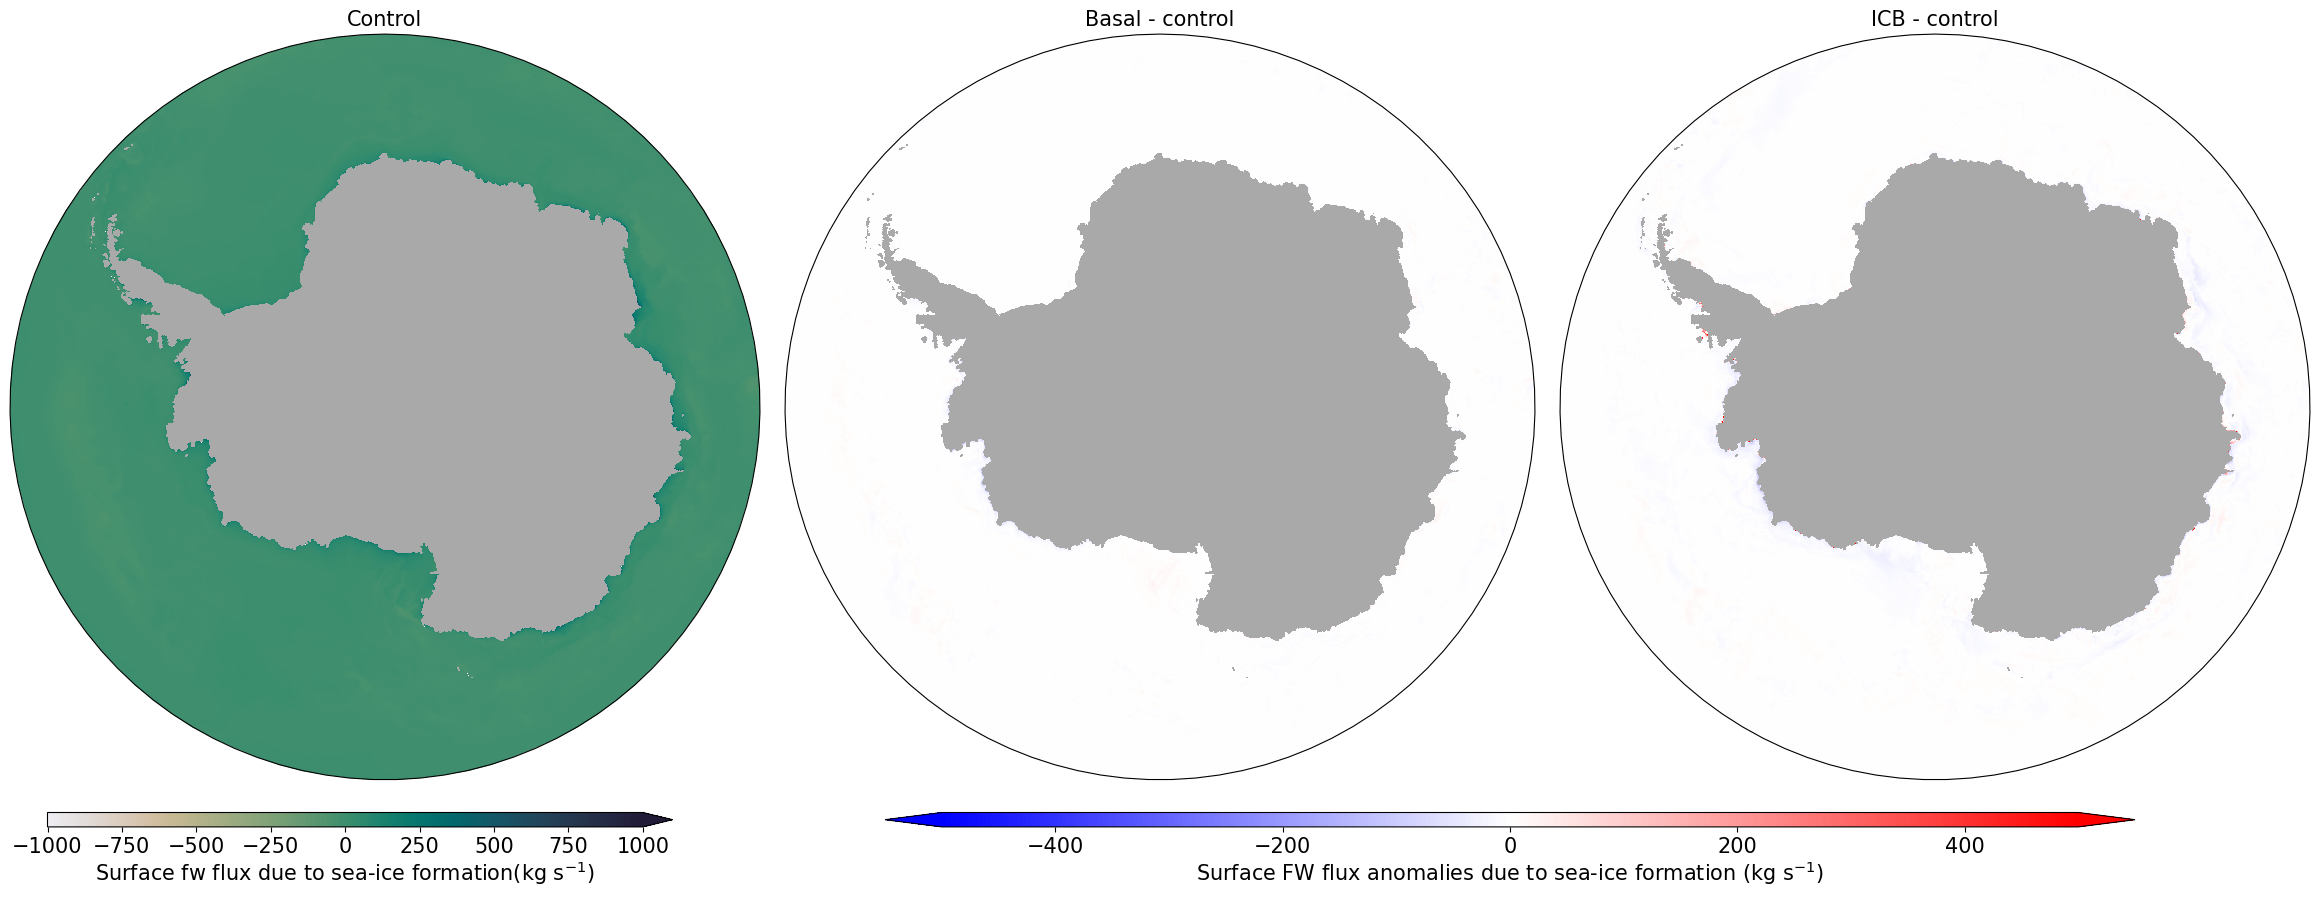

In [55]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-1000
rmax=1000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(FW_ice.xt_ocean, FW_ice.yt_ocean, FW_ice.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-500
rmax=500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(FW_ice_noBG.xt_ocean, FW_ice_noBG.yt_ocean, FW_ice_noBG.mean('time')*area_t - FW_ice.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(FW_ice_ICB.xt_ocean, FW_ice_ICB.yt_ocean, FW_ice_ICB.mean('time')*area_t - FW_ice.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface fw flux due to sea-ice formation(kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface FW flux anomalies due to sea-ice formation (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)


### Save fig
plt.savefig(figdir+'FW_ice_anom_noBG_ICBB_y'+str(year)+'.png')

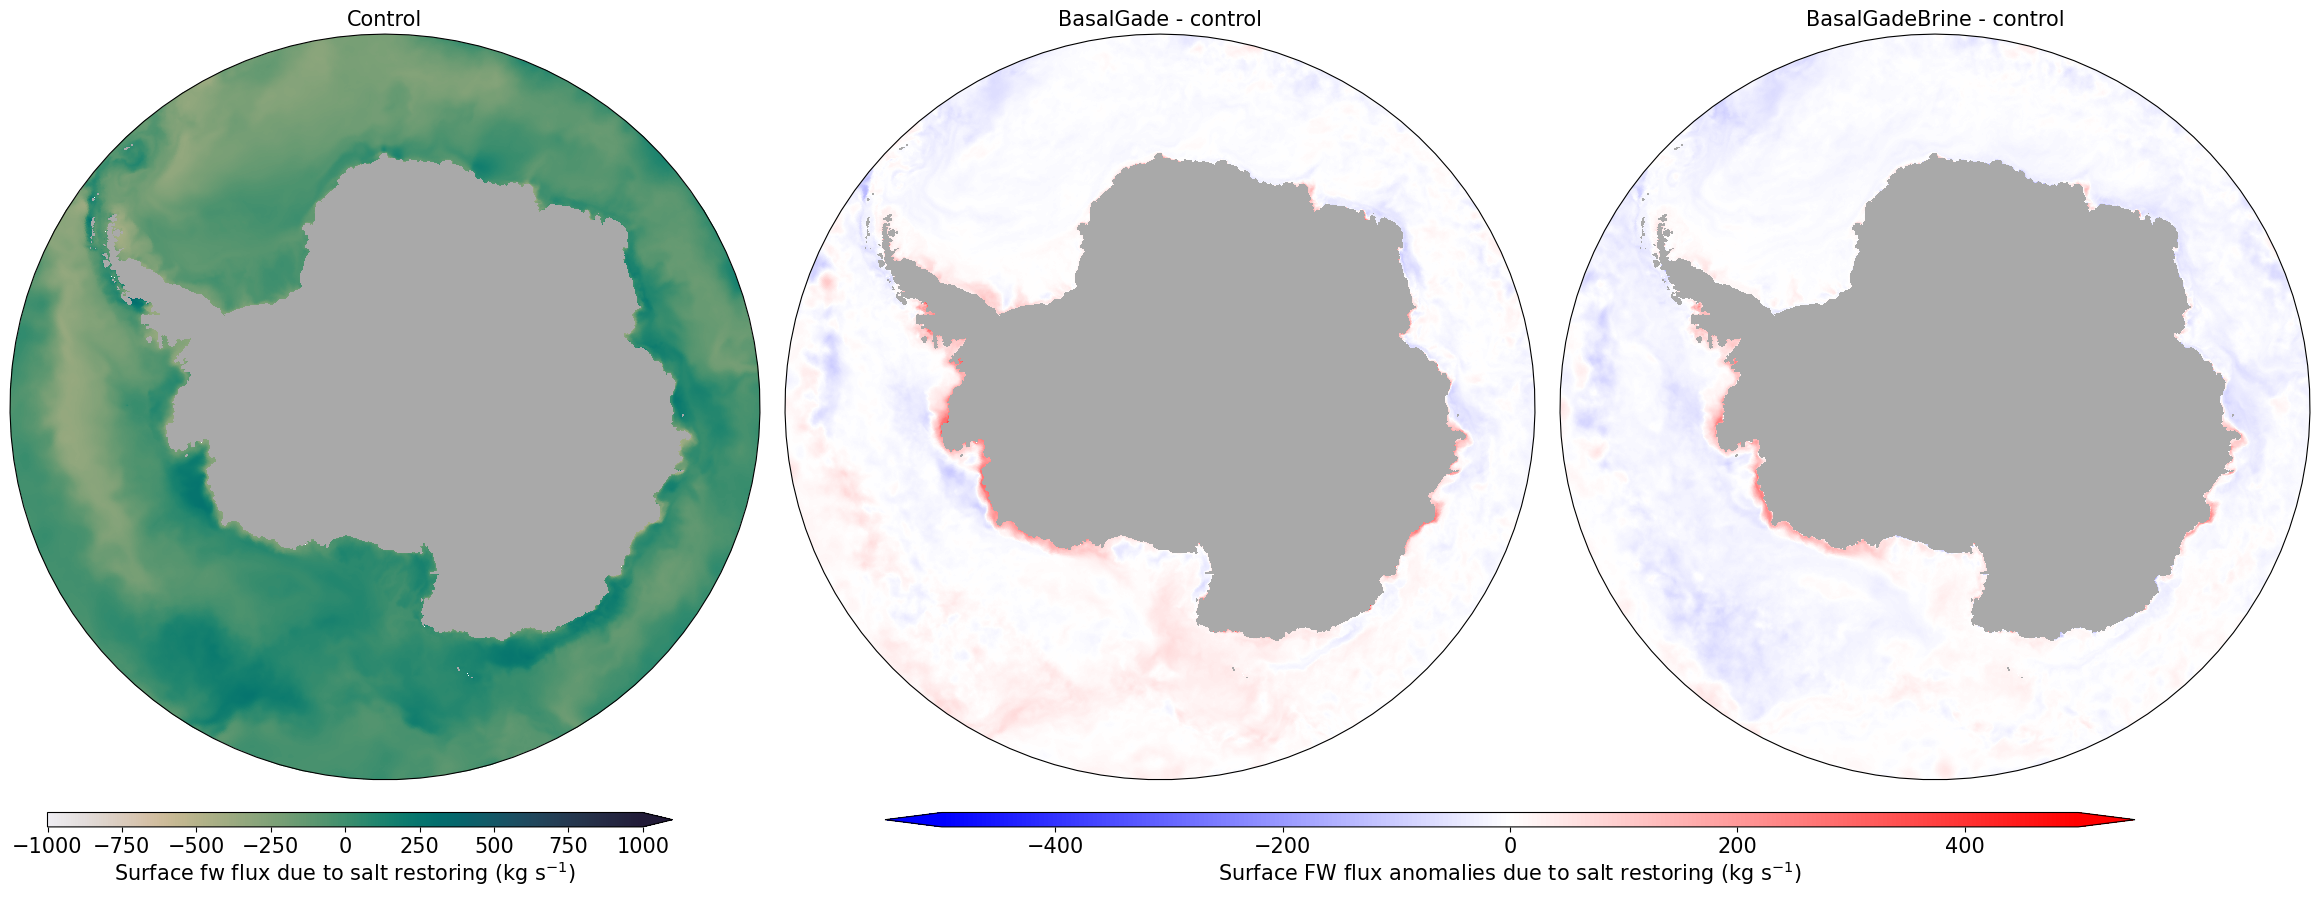

In [56]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-1000
rmax=1000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(FW_restore.xt_ocean, FW_restore.yt_ocean, FW_restore.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-500
rmax=500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(FW_restore_BG.xt_ocean, FW_restore_BG.yt_ocean, FW_restore_BG.mean('time')*area_t - FW_restore.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGade - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sina(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(FW_restore_BGB.xt_ocean, FW_restore_BGB.yt_ocean, FW_restore_BGB.mean('time')*area_t - FW_restore.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('BasalGadeBrine - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface fw flux due to salt restoring (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface FW flux anomalies due to salt restoring (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'FW_restore_anom_BG_BGB_y'+str(year)+'.png')

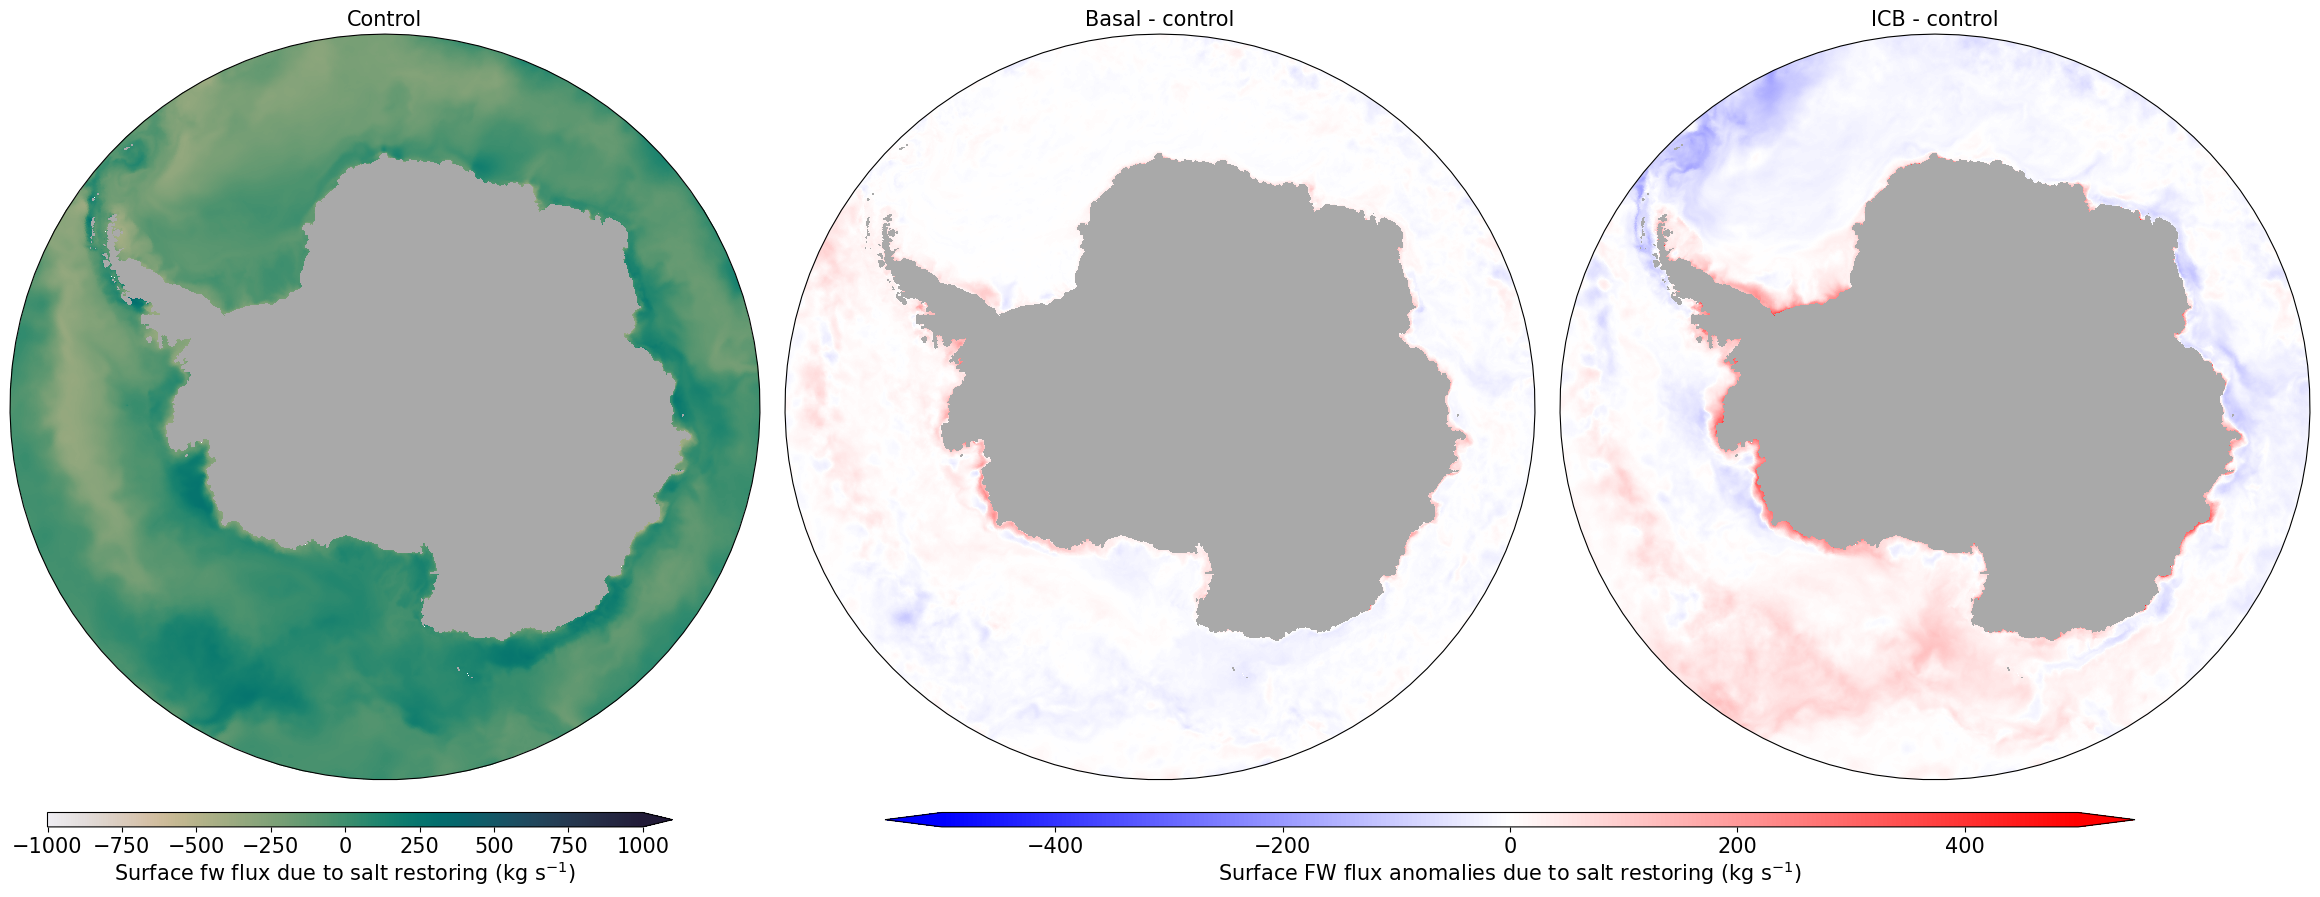

In [58]:
# fig2: maps annual-avg last year (yr10)

year = 10
scale_max = 1.2
rmin=-1000
rmax=1000

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# control
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cf = ax.pcolormesh(FW_restore.xt_ocean, FW_restore.yt_ocean, FW_restore.mean('time')*area_t, #norm = norm,
    cmap = cmocean.rain, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())


rmin=-500
rmax=500

# basal
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plot:
cfa = ax.pcolormesh(FW_restore_noBG.xt_ocean, FW_restore_noBG.yt_ocean, FW_restore_noBG.mean('time')*area_t - FW_restore.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# diff
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sina(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cfa = ax.pcolormesh(FW_restore_ICB.xt_ocean, FW_restore_ICB.yt_ocean, FW_restore_ICB.mean('time')*area_t - FW_restore.mean('time')*area_t, #norm = norm,
    cmap = cm.bwr, transform = ccrs.PlateCarree(), vmin=rmin, vmax=rmax)
# ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB - control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.015, 0.15, 0.25, 0.012]) #
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'horizontal',extend = 'max')
cbar.set_label(r'Surface fw flux due to salt restoring (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

cbaxes = fig.add_axes([0.35, 0.15, 0.5, 0.012]) #
cbar = plt.colorbar(cfa, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Surface FW flux anomalies due to salt restoring (kg s$^{-1}$)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

### Save fig
plt.savefig(figdir+'FW_restore_anom_noBG_ICB_y'+str(year)+'.png')